# Description

Disini saya diminta oleh sebuah perusahaan telekomunikasi. Perusahaan ini menawarkan dua paket prabayar Surf dan Ultimate.Departemen periklanan ingin mengetahui paket prabayar mana yang menghasilkan lebih banyak pendapatan untuk menyesuaikan anggaran iklan. Tugas saya disini adalah menganalisis perilaku klien dan menentukan paket prabayar mana yang mendatangkan lebih banyak pendapatan

# GOALS

    1.Meganalisis penggunaan antara kedua paket surf dan internet
    2.Melihat profit yang dihasilkan masing-masing paket
    3.Melihat outlier data dari masing masing paket yang ditawarkan 
    4. Uji hipotesis :
        a. rata-rata proft antara pengguna paket
        b. rata-rata profit pengguna yang tinggal di kota NY dan tempat lain

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
#memuat dataset
call_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_calls.csv')
internet_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_internet.csv')
message_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_messages.csv')
plan_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_plans.csv')
user_data = pd.read_csv('https://practicum-content.s3.us-west-1.amazonaws.com/datasets/megaline_users.csv')

In [3]:
#melihat apakah info tipe data dan melihat apakah ada nilai yang null
data = [call_data,internet_data,message_data,plan_data,user_data]
for i in data:
    i.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  D

In [118]:
#transformasi data menjadi datetime, karena data bertipe tanggal
call_data['call_date'] = pd.to_datetime(call_data['call_date'])
call_data.head(5)

,id,user_id,call_date,duration,duration_round,month
0,1000_93,1000,2018-12-27,8.52,9.0,12
1,1000_145,1000,2018-12-27,13.66,14.0,12
2,1000_247,1000,2018-12-27,14.48,15.0,12
3,1000_309,1000,2018-12-28,5.76,6.0,12
4,1000_380,1000,2018-12-30,4.22,5.0,12


In [119]:
#transformasi data menjadi datetime, karena data bertipe tanggal
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'])
internet_data.head(5)

,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12
1,1000_204,1000,2018-12-31,0.00,12
2,1000_379,1000,2018-12-28,660.40,12
3,1000_413,1000,2018-12-26,270.99,12
4,1000_442,1000,2018-12-27,880.22,12


In [120]:
message_data['message_date'] =  pd.to_datetime(message_data['message_date'])
#message_data.head(5)


In [7]:
plan_data.head(5)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [8]:
user_data.head(5)
user_data['reg_date'] = pd.to_datetime(user_data['reg_date'])

In [121]:
#mengisi column churn_date yang NaN dengan "masih berlangganan" , karena column ini maksudnya adalah kapan berhenti menggunakan paket,
#jadi jika nilai NaN artinya pelanggan masing berlangganan paket
user_data['churn_date'] = user_data['churn_date'].fillna('masih berlangganan')

In [10]:
user_data

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,masih berlangganan
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,masih berlangganan
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,masih berlangganan
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,masih berlangganan
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,masih berlangganan
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,masih berlangganan
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,masih berlangganan
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,masih berlangganan
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,masih berlangganan


In [11]:
#mencari jumlah panggilan pengguna perbulan dalam menit, lalu mengelompokkan durasi telepon berdsarkan penggunaan user per bulan
call_data['duration_round'] = call_data['duration'].apply(np.ceil)
call_data['month'] = call_data['call_date'].dt.month
call_data

,id,user_id,call_date,duration,duration_round,month
0,1000_93,1000,2018-12-27,8.52,9.0,12
1,1000_145,1000,2018-12-27,13.66,14.0,12
2,1000_247,1000,2018-12-27,14.48,15.0,12
3,1000_309,1000,2018-12-28,5.76,6.0,12
4,1000_380,1000,2018-12-30,4.22,5.0,12
...,...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72,9.0,11
137731,1499_200,1499,2018-10-20,10.89,11.0,10
137732,1499_201,1499,2018-09-21,8.12,9.0,9
137733,1499_202,1499,2018-10-10,0.37,1.0,10


In [122]:
#menghitung total panggilan dalam 1 bulan beserta durasi panggilannya untuk per user_id
call = call_data.groupby(['user_id','month']).agg({'duration':'sum','call_date':'count'}).rename(columns={'call_date':'total_call'}).reset_index()
call = call.rename(columns={'duration':'call_duration'})
call

,user_id,month,call_duration,total_call
0,1000,12,116.83,16
1,1001,8,171.14,27
2,1001,9,297.69,49
3,1001,10,374.11,65
4,1001,11,404.59,64
...,...,...,...,...
2253,1498,12,324.77,39
2254,1499,9,330.37,41
2255,1499,10,363.28,53
2256,1499,11,288.56,45


In [123]:
#mengelompokkan berapa pesan yang dikirim oleh user dalam satu bulan
message_data['month']=message_data['message_date'].dt.month
message = message_data.groupby(['user_id','month']).agg({'message_date':'count'}).reset_index().rename(columns={'message_date':'total_message'})
message

,user_id,month,total_message
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [14]:
#mengelompokkan total penggunaan internet user dalam 1 bulan lalu menambahkan kolom gb_user sebagai konversi penggunaan internet
#pengguna dalam satuan GBps
internet_data['month'] = internet_data['session_date'].dt.month
internet = internet_data.groupby(['user_id','month']).agg({'mb_used':'sum'}).reset_index()
internet['gb_used'] = (internet['mb_used']/1024).round()
internet = internet
internet

,user_id,month,mb_used,gb_used
0,1000,12,1901.47,2.0
1,1001,8,6919.15,7.0
2,1001,9,13314.82,13.0
3,1001,10,22330.49,22.0
4,1001,11,18504.30,18.0
...,...,...,...,...
2272,1498,12,23137.69,23.0
2273,1499,9,12984.76,13.0
2274,1499,10,19492.43,19.0
2275,1499,11,16813.83,16.0


In [15]:
#menggabungkan kolom total call,message,data usage dalam 1 bulan tadi berdasarkan user_id
merge1 = call.merge(internet,on=['user_id','month'],how='inner')
merge2 = merge1.merge(message,on=['user_id','month'],how='inner')
merge3 = user_data.merge(merge2,on='user_id')
#plan_data
data_consumption = merge3.merge(plan_data,left_on='plan',right_on='plan_name')

In [124]:
data_consumption

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,call_duration,...,total_message,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,profit
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,masih berlangganan,12,116.83,...,11,1000,30720,3000,70,7,0.01,0.01,ultimate,70.000000
1,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,11,9.32,...,15,1000,30720,3000,70,7,0.01,0.01,ultimate,70.000000
2,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,12,54.79,...,139,1000,30720,3000,70,7,0.01,0.01,ultimate,79.562246
3,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,masih berlangganan,10,450.21,...,21,1000,30720,3000,70,7,0.01,0.01,ultimate,70.000000
4,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,masih berlangganan,11,422.81,...,37,1000,30720,3000,70,7,0.01,0.01,ultimate,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,masih berlangganan,8,114.62,...,2,50,15360,500,20,10,0.03,0.03,surf,20.000000
1755,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,masih berlangganan,9,389.94,...,21,50,15360,500,20,10,0.03,0.03,surf,30.051465
1756,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,masih berlangganan,10,301.16,...,18,50,15360,500,20,10,0.03,0.03,surf,20.000000
1757,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,masih berlangganan,11,291.88,...,13,50,15360,500,20,10,0.03,0.03,surf,20.000000


In [17]:
#fungsi yang digunakan untuk mencari total profit dari masing masing user yang berlangganan paket, karena setiap paket ada
#batas penggunaanya, jika batas penggunaanya terlewati maka untuk setiap kelebihan penggunaan akan dikenakan biaya lagi sesuai
#dengan yang ditentukan

def revenue(row):
    call_profit = row['call_duration'] - row['minutes_included']
    data_profit = row['mb_used']-row['mb_per_month_included']
    message_profit = row['total_message'] - row['messages_included']
    profit_total = 0;
    if call_profit > 0:
        profit_total += call_profit*row['usd_per_minute']
    if data_profit > 0:
        profit_total += (data_profit/1024) * row['usd_per_gb']
    if message_profit >0:
        profit_total += message_profit* row['usd_per_message']
    return profit_total + row['usd_monthly_pay']

In [125]:
#menambahkan kolom baru bernama profit, kolom ini menampilkan biaya yang dikeluarkan masing masing pelanggan, biaya bulanan langganan
#sekaligus biaya kelebihan batas paket yang di pakai
data_consumption['profit']  = data_consumption.apply(revenue,axis=1)

In [19]:
data_consumption.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month,call_duration,...,total_message,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,profit
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,masih berlangganan,12,116.83,...,11,1000,30720,3000,70,7,0.01,0.01,ultimate,70.000000
1,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,11,9.32,...,15,1000,30720,3000,70,7,0.01,0.01,ultimate,70.000000
2,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,12,54.79,...,139,1000,30720,3000,70,7,0.01,0.01,ultimate,79.562246
3,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,masih berlangganan,10,450.21,...,21,1000,30720,3000,70,7,0.01,0.01,ultimate,70.000000
4,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,masih berlangganan,11,422.81,...,37,1000,30720,3000,70,7,0.01,0.01,ultimate,70.000000


In [23]:
#melihat distribusi masing masing paket berdasarkan rata-rata, standard deviasi dan variance
data_stat = data_consumption.groupby('plan')['call_duration','mb_used','total_message'].agg({'mean','var','std'})
data_stat

C:\Users\laure\AppData\Local\Temp\ipykernel_20216\2120914817.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_stat = data_consumption.groupby('plan')['call_duration','mb_used','total_message'].agg({'mean','var','std'})


call_duration                                mb_used                \
                  mean           var        std          mean           var   
plan                                                                          
surf        420.778483  49492.562612  222.46924  16629.018297  5.951014e+07   
ultimate    417.562159  55607.233145  235.81186  17250.995838  5.909048e+07   

                      total_message                          
                  std          mean          var        std  
plan                                                         
surf      7714.281647     39.489831  1044.217878  32.314360  
ultimate  7687.033067     46.455959  1084.393818  32.930135

In [34]:
#Membagi kelompok pengguna menjadi yang berlangganan paket surf dan paket ultimate
data_surf = data_consumption[data_consumption['plan_name']=='surf']
data_ultimate = data_consumption[data_consumption['plan_name']=='ultimate']

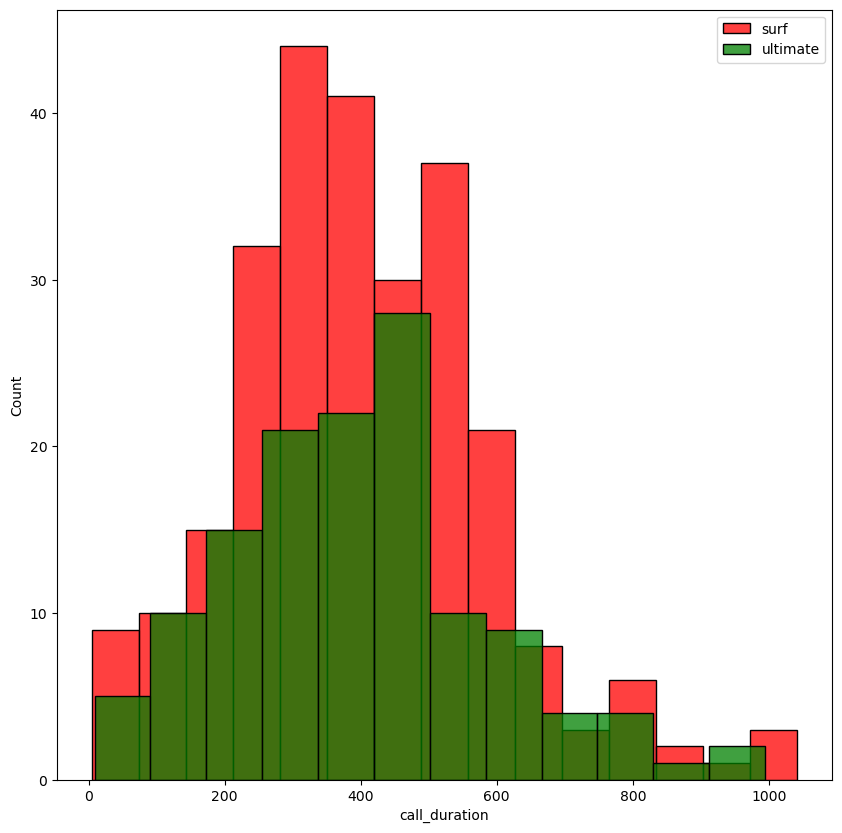

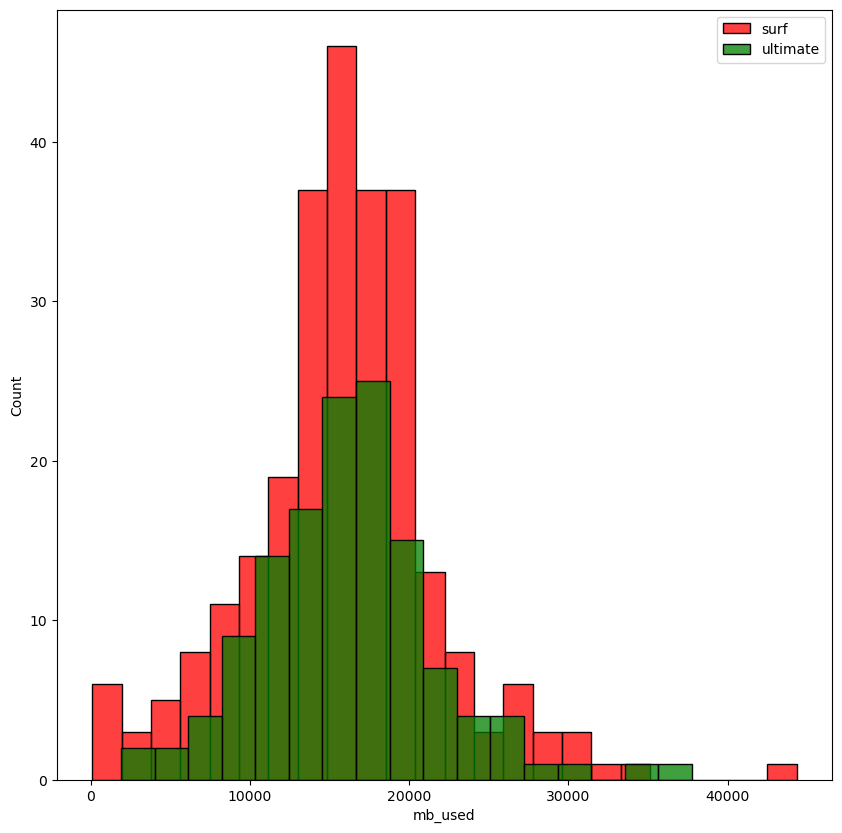

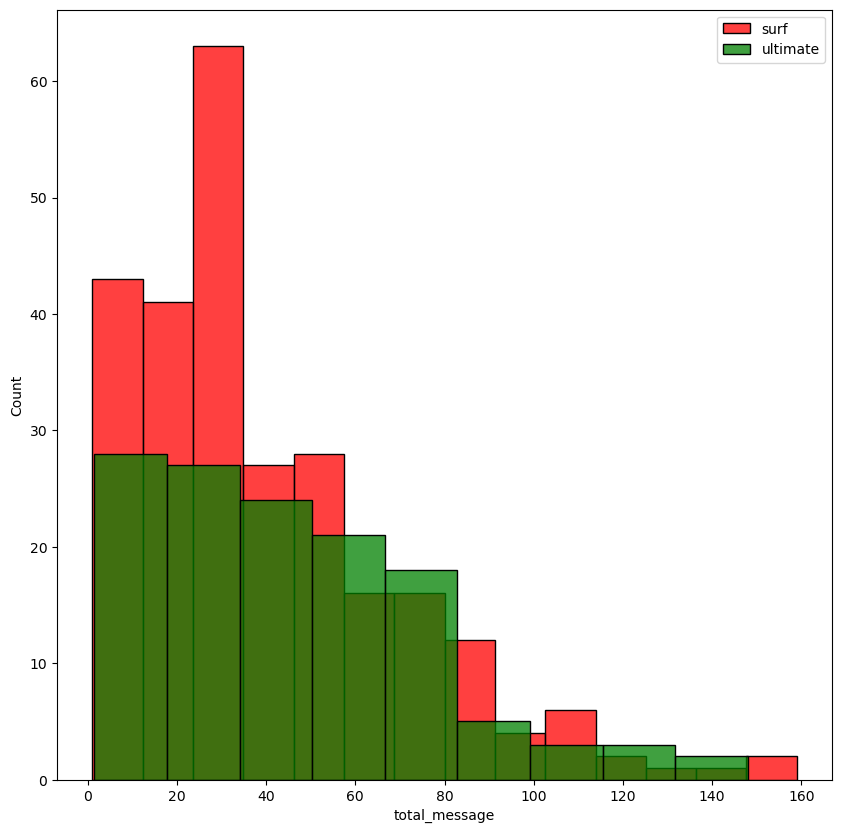

In [127]:
#melihat rata-rata penggunaan fitur yang paket tawarkan seperti rata=rata panggilan,total pesan, data yang digunakan untuk setiap paket
param = ['call_duration','mb_used','total_message']
for i in param:
    plt.figure(figsize=(10,10))
    sns.histplot(data_surf.groupby('user_id')[i].mean(),color='red',label='surf')
    sns.histplot(data_ultimate.groupby('user_id')[i].mean(),color='green',label='ultimate')
    plt.legend()

C:\Users\laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


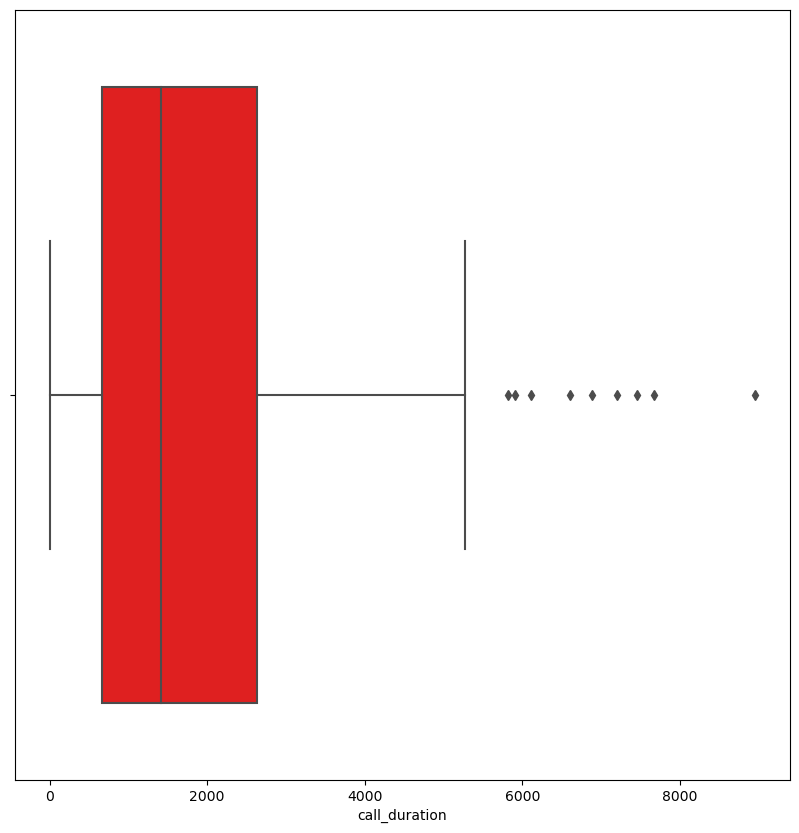

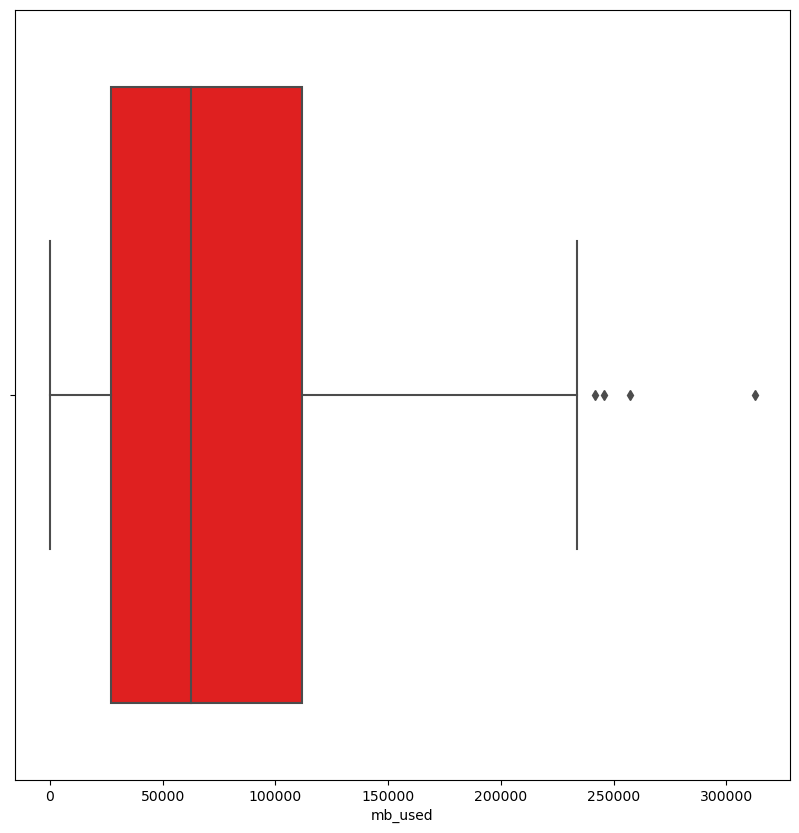

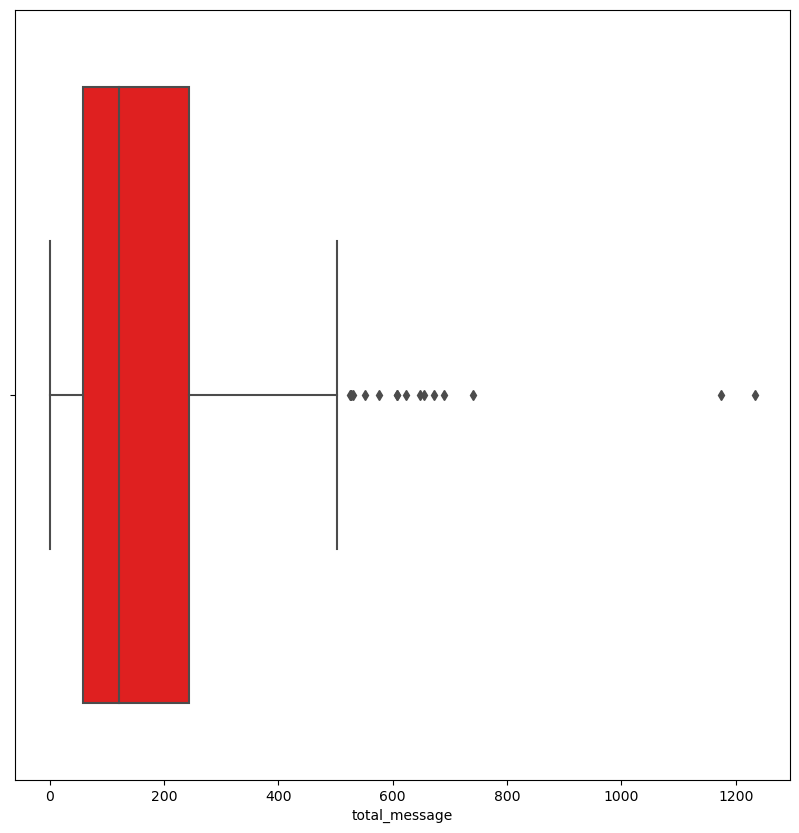

In [63]:
#melihat total penggunaan paket surf untuk setiap fitur yang diberikan
for j in param :
    plt.figure(figsize=(10,10))
    sns.boxplot(data_surf.groupby('user_id')[j].sum(),color='red')

C:\Users\laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\laure\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


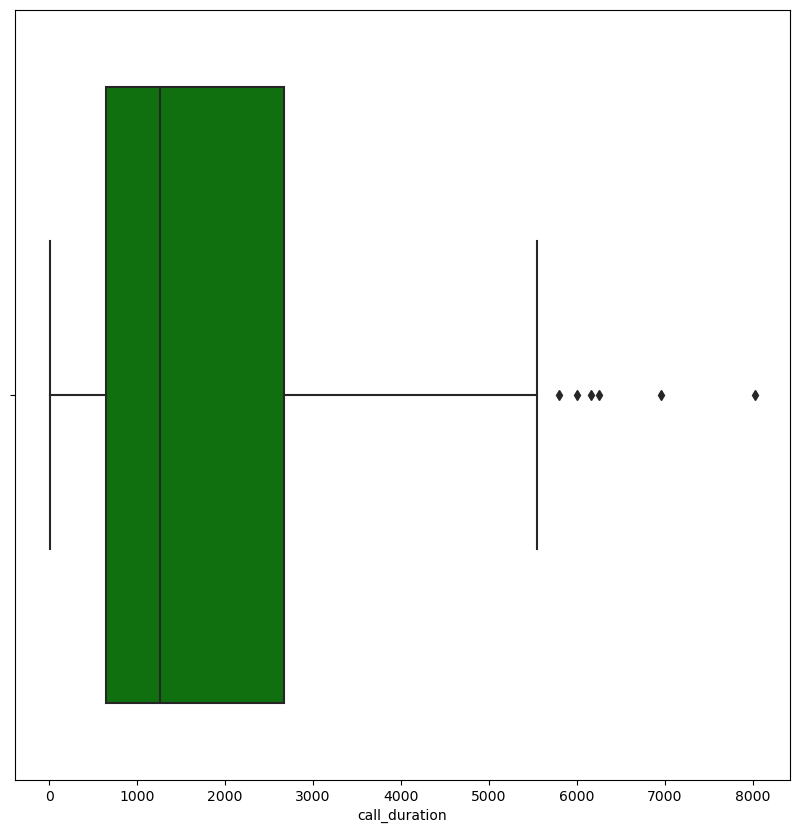

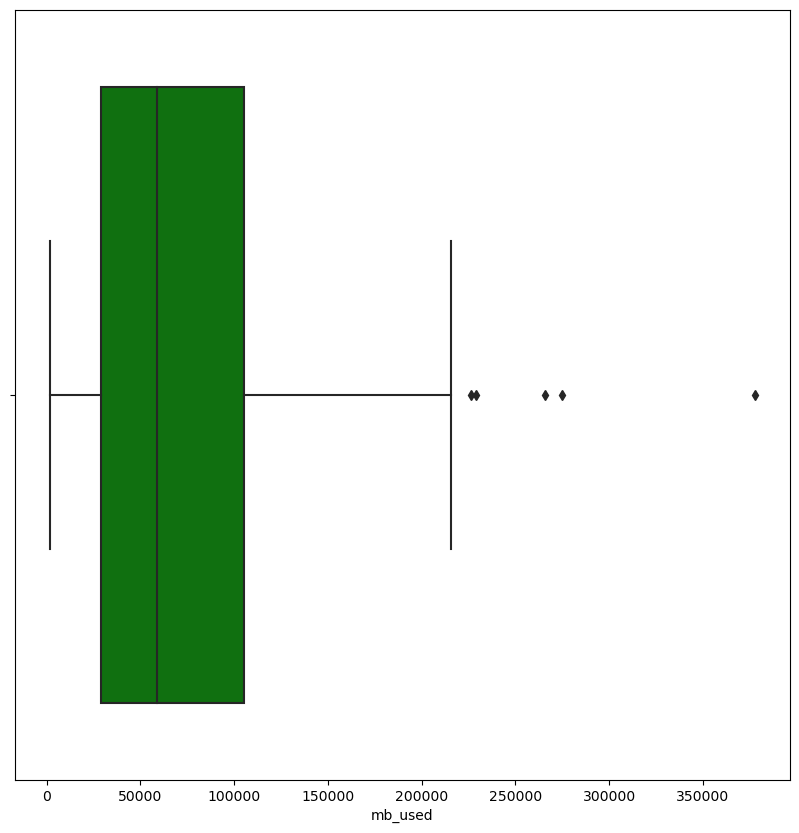

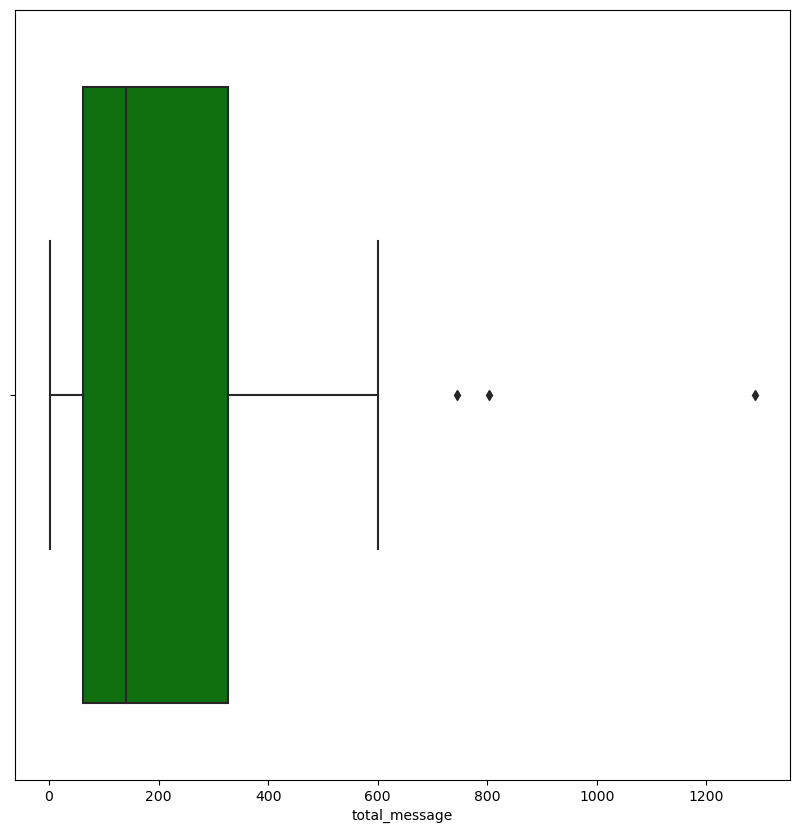

In [59]:
#melihat total penggunaan paket ultimate untuk setiap fitur yang diberikan

for j in param :
    plt.figure(figsize=(10,10))
    sns.boxplot(data_ultimate.groupby('user_id')[j].sum(),color='green')


  plan_name   profit
0      surf  67115.0
1  ultimate  41724.0


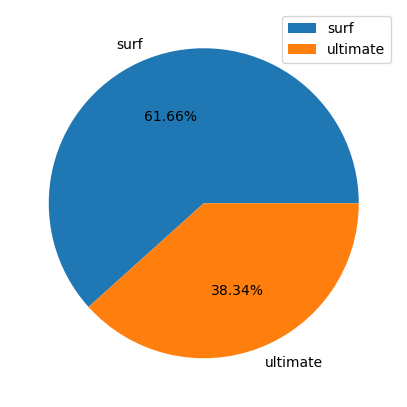

In [131]:
#melihat total profit yang dihasilkan oleh masing-masing paket
profit_total=  data_consumption.groupby('plan_name')['profit'].sum().reset_index().round()
plt.figure(figsize=(5,10))
plt.pie(profit_total['profit'],labels=profit_total['plan_name'],autopct='%1.2f%%')
plt.legend()
print(profit_total)

## Uji hipotesis

In [81]:
#menguji apakah profit dari pake plan ultimate dan surf sama
#H0 : profit yang didapat dari paket surf dan ultimate sama
#H1 : profit yang didapat dari paket surf dan ultimate berbeda
alpha = 0.05
result1 = st.ttest_ind(data_surf['profit'],data_ultimate['profit'],equal_var = False)


In [83]:
pvalue = result1.pvalue
if pvalue < alpha:
    print('dapat menolak H0, profit yang didapat dari paket surf dan ultimate berbeda')
else:
    print('tidak dapat menolak H0,profit yang didapat dari paket surf dan ultimate sama')

dapat menolak H0, profit yang didapat dari paket surf dan ultimate berbeda


In [116]:
#menguji rata-rata pendapatan dari pengguna di wilayah NY-NJ berbeda dengan pendapatan pengguna dari wilayah lain.
is_NY_NJ = data_consumption[data_consumption['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']
other = data_consumption[data_consumption['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']
result2 = st.ttest_ind(is_NY_NJ['profit'],other['profit'])

In [133]:
result2
pvalue = result2.pvalue

if pvalue < alpha:
    print('dapat menolak H0,rata-rata pendapatan profit dari pengguna di wilayah NY-NJ sama dengan pendapatan pengguna dari wilayah lain')
else:
    print('tidak dapat menolak H0,rata-rata pendapatan profit dari pengguna di wilayah NY-NJ berbeda dengan pendapatan pengguna dari wilayah lain')

dapat menolak H0,rata-rata pendapatan profit dari pengguna di wilayah NY-NJ sama dengan pendapatan pengguna dari wilayah lain


# Kesimpulan

    
1. Dari segi penggunaan paket prabayar, penggunaan fitur di paket surf lebih banyak, baik pada call duration, total message, dan penggunaan paket internet, terlihat pada histogram diatas, rata-ratanya lebih banyak penggunaan paket surf dengan rata-rata:

- penggunaan panggilan : penyebarannya ada di kisaran 200 - 600 menit dan penggunanya bisa sampai 0-45 			       orang sedangkan paket ultimate penyebarannya ada dikisaran 200 - 400 menit dan 			       penggunanya hanya 0-20 orang

- mb_used : untuk paket surf penyebarannya ada di 0-20000 mb dan penggunanya di kisaran 0-40 pengguna  penyebarannya sedangkan paket ultimate penyebarannya hanya di 0-15000 dan penggunanya di kisaran 0-25 pengguna 

- total_message : untuk total rata-rata pesan yang dikirim ada sedikit perbedaan dibanding 2 fitur 		        lainnya, disini pengguna paket surf mengirimkan rata-rata total pesan lebih sedikit 			yaitu penyebarannya di kisaran 0-50  pesan dibanding paket ultimate yang rata-rata pengiriman pesan lebih banyak yang dikisaran 0-80 pesan tetapi dari jumlah penggunanya rata rata pengguna total_pesan ini lebih banyak di 
pengguna paket surf dengan kisaran 0-60 orang dibanding paket ultimate yang penggunanya 		di kisaran 0-30

2. Untuk profit yang dihasilkan masing masing paket lebih banyak dihasilkan oleh paket suft dengan menumbang  67115 sedangkan paket ultimate profitnya hanya   41724


3. dari outlier data yang dihasilkan untuk masing masing paket:
        -surf:
             -total call : ada pengguna yang menggunakan mencapai 8000 menit
             -mb used : ada pengguna yang menggunakan mencapai 30000 mb
             -total message : ada pengguna yang menggunakan samapi 1200 pesan yang dikirim
        -ultimate:
             -total call : ada pengguna yang menggunakan mencapai 8000 menit
             -mb used : ada pengguna yang menggunakan mencapai 35000 mb
	     -total message : ada pengguna yang menggunakan samapi 1300 pesan yang dikirim
4. Uji hipotesis, untuk uji hipotesis yang dilakukan didapat:
   a. profit yang didapat dari paket surf dan ultimate berbeda
   b. rata-rata pendapatan profit dari pengguna di wilayah NY-NJ sama dengan pendapatan pengguna dari     
      wilayah lain


# Saran

    1. Menaikkan harga paket surf sehingga bisa mendapat kenaikan profit
    2. Menambah batasan paket ultimate,sehingga pelanggan yang merasa pengguna surf beralih ke Ultimate, karena rata-rata pengguna paket surf banyak yang melebihi batasan paket sehingga membayar biaya tambahan, sedangkan biaya tambahan paket surf lebih banyak dibanding paket ultimate
    3. Menambah biaya tambahan jika melebihi batas pengguna paket surf, karena perilakuk pengguna paket surf sering melebihi batas penggunaan sehingga perusahaan bisa mendapat untung yang lebih